# Day-Averaged Yearly Profiles clustering

In [2]:
import polars as pl
import re
import glob
import numpy as np
import os
import matplotlib.pyplot as plt
import logging
from datetime import date, datetime
from datetime import timedelta
from pathlib import Path

from tslearn.clustering import TimeSeriesKMeans 
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans

from validation import validation
from Hyperparameters_KMeans import optimize_kmeans

logging.getLogger('matplotlib.font_manager').disabled = True

timestamp_range = pl.datetime_range(datetime(2024, 1, 1), datetime(2024, 12, 31), "1d", eager=True).cast(pl.Date)

## Extracting and preparing files for clustering

In [3]:
def day_avg_preprocess(df, timestamp_range):
    
    df = df.with_columns(
        pl.col("zeitpunkt").str.strptime(pl.Datetime, format="%Y-%m-%dT%H:%M:%S%z", strict=False).alias("zeitpunkt_dt")
    )
    
    df = df.with_columns(
        pl.col("zeitpunkt_dt").dt.date().alias("date")
    )

    date_list = timestamp_range.to_list()

    day_avg = (
        df.filter(pl.col("date").is_in(date_list))
          .group_by("date")
          .agg(pl.col("bruttolastgang_kwh").mean().alias("day_avg_bruttolastgang_kwh"))
          .sort("date")
    )
    return day_avg

def normalize(df):
    """ Normalize the 'day_avg_bruttolastgang_kwh' column by its max value and overwrite the original column """
    
    max_val = df.select(pl.max("day_avg_bruttolastgang_kwh"))['day_avg_bruttolastgang_kwh'][0]
    
    if max_val == 0:
        # Avoid division by zero, leave values unchanged
        df = df.with_columns(
            pl.col("day_avg_bruttolastgang_kwh")
        )
    else:
        # Overwrite original column with normalized values
        df = df.with_columns(
            (pl.col("day_avg_bruttolastgang_kwh") / max_val).alias("day_avg_bruttolastgang_kwh")
        )
    
    df = df.sort("date")
    
    return df

# Define the input file pattern
pattern = "/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_cleaned/*CH*.csv"
file_paths = glob.glob(pattern)

# Define the output directory
output_dir = Path("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_day_avg_normalized")
output_dir.mkdir(parents=True, exist_ok=True)

for file_path in file_paths:
    df = pl.read_csv(file_path)
    day_avg = day_avg_preprocess(df, timestamp_range)
    day_avg = normalize(day_avg)
    
    filename = os.path.basename(file_path)  # gets file name with extension
    output_file = output_dir / filename      # construct output path
    
    day_avg.write_csv(output_file)

    

## Daily-average Clustering over the year 2024

In [4]:
input_folder = Path("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_day_avg_normalized")

pattern = str(input_folder / "*CH*.csv")
file_paths = glob.glob(pattern)

In [5]:
n_timestamps = len(timestamp_range)

data_list = []
filename_list = []

pattern = re.compile(r"(CH[^_\.]*)")  # Matches 'CH' followed by any chars except _ or .

for idx, file_path in enumerate(file_paths):
    df = pl.read_csv(file_path)
    if len(df) == n_timestamps:
        values_array = df["day_avg_bruttolastgang_kwh"].to_numpy().reshape((1, n_timestamps, 1))
        data_list.append(values_array)
        
        base = os.path.basename(file_path)
        match = pattern.search(base)
        if match:
            filename_list.append(match.group(1))
        else:
            filename_list.append(base)  # fallback to full basename if no CH... found

if data_list:
    data_3d = np.concatenate(data_list, axis=0)
    print(f"Shape of the 3D array: {data_3d.shape}")

print(filename_list[:10])  # Preview first 10 extracted CH... names

train_data = data_3d



Shape of the 3D array: (1464, 366, 1)
['CH1018601234500000000000000040851', 'CH1018601234500000000000000047828', 'CH1018601234500000000000000112970', 'CH1018601234500000000000000076787', 'CH1018601234500000000000000067786', 'CH1018601234500000000000000036798', 'CH1018601234500000000000000065363', 'CH1018601234500000000000000065862', 'CH1018601234500000000000000024655', 'CH1018601234500000000000000070197']


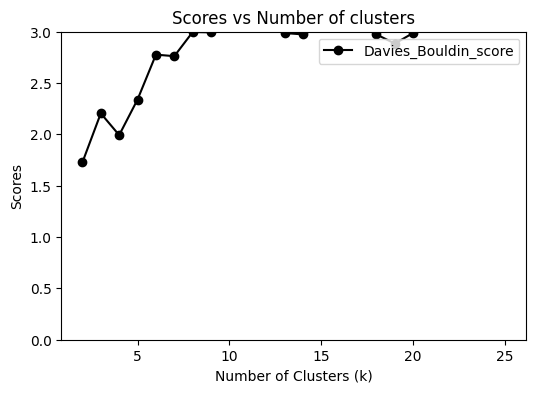

1.7273212063122658

Best combination of hyperparameters:
n_clusters                  4
init                k-means++
n_init                      1
max_iter                  100
silhouette_score     0.130058
db_score              1.99298
Name: 25, dtype: object


n_clusters                  4
init                k-means++
n_init                      1
max_iter                  100
silhouette_score     0.130058
db_score              1.99298
Name: 25, dtype: object

In [6]:
validation(train_data)

optimize_kmeans(train_data)


In [11]:


n_clusters = 4  # Number of clusters, you can adjust this
max_iterations =100

kmeans = TimeSeriesKMeans(n_clusters=n_clusters,max_iter=max_iterations, verbose=False, random_state=42, n_jobs=-1)
clusters_train = kmeans.fit_predict(train_data)

In [12]:
# saves the found clusters in a csv file with the corresponding household IDs

# Convert filename_list items to strings
house_ids = [str(h) for h in filename_list]

# Creates Polars DataFrame with house IDs and clusters
result_df = pl.DataFrame({
    "house_id": house_ids,
    "cluster": clusters_train + 1
}).sort("cluster")
result_df.write_csv("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/day_avg_clustering.csv")

In [13]:
# total number of households per cluster, total energy consumption per cluster, averga eenergy consumption per cluster daily and anually

# Convert filename_list items to strings if not already
house_ids = [str(h) for h in filename_list]

# Create Polars DataFrame with house IDs and clusters
result_df = pl.DataFrame({
    "house_id": house_ids,
    "cluster": clusters_train + 1  # adjust if needed
})

# Read the alle_mittelwerte file
alle_mittelwerte_df = pl.read_csv("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/alle_mittelwerte.csv")  # Adjust path as needed

# Normalize keys in all DataFrames for clean join
# Normalize keys
result_df = result_df.with_columns(
    pl.col("house_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("ch_id_clean")
)

alle_mittelwerte_df = alle_mittelwerte_df.with_columns(
    pl.col("file_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("ch_id_clean")
)

result_df = result_df.join(
    alle_mittelwerte_df.select([
        "ch_id_clean",
        "bruttolastgang_kwh_sum",
        "average_daily_consumption"
    ]),
    on="ch_id_clean",
    how="left"
)
# Now select in the desired order
result_df = result_df.select([
    "house_id",
    "cluster",
    "bruttolastgang_kwh_sum",
    "average_daily_consumption"  
])

#print(result_df.head())

cluster_summary = result_df.group_by("cluster").agg([
    pl.count("house_id").alias("num_households"),
    pl.mean("bruttolastgang_kwh_sum").alias("avg_yearly_consumption [kWh]"),
    pl.mean("average_daily_consumption").alias("avg_daily_consumption [kWh]")
]).sort("cluster")

print(cluster_summary)

shape: (4, 4)
┌─────────┬────────────────┬──────────────────────────────┬─────────────────────────────┐
│ cluster ┆ num_households ┆ avg_yearly_consumption [kWh] ┆ avg_daily_consumption [kWh] │
│ ---     ┆ ---            ┆ ---                          ┆ ---                         │
│ i64     ┆ u32            ┆ f64                          ┆ f64                         │
╞═════════╪════════════════╪══════════════════════════════╪═════════════════════════════╡
│ 1       ┆ 307            ┆ 3002.726238                  ┆ 5.029411                    │
│ 2       ┆ 408            ┆ 5028.40086                   ┆ 8.910476                    │
│ 3       ┆ 581            ┆ 3305.854775                  ┆ 5.661155                    │
│ 4       ┆ 168            ┆ 9471.606018                  ┆ 14.980012                   │
└─────────┴────────────────┴──────────────────────────────┴─────────────────────────────┘


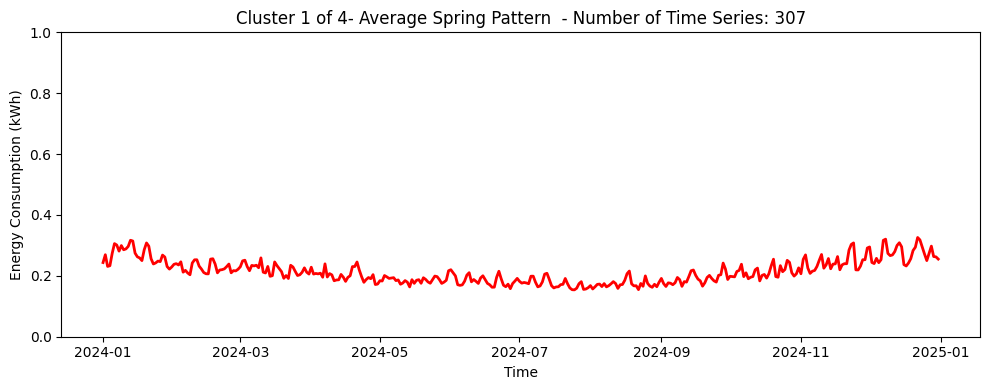

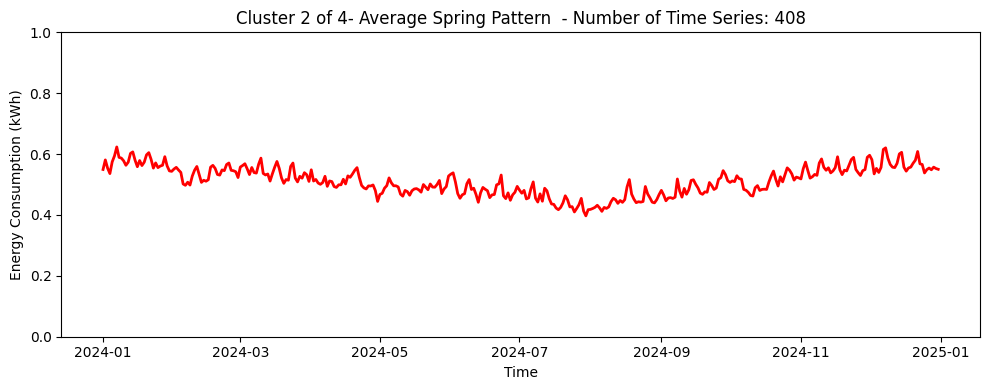

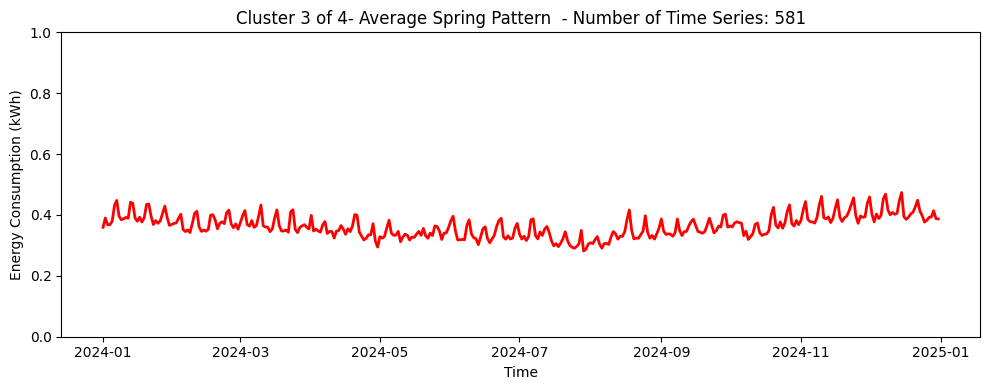

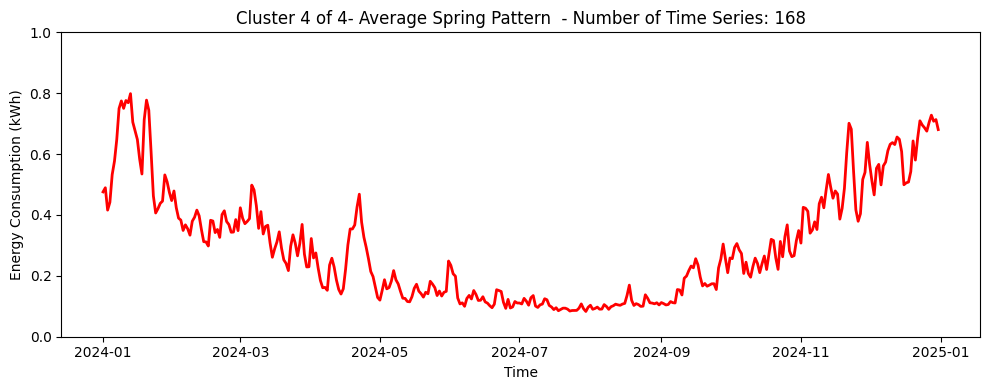

In [14]:
save = 0 #if you want to save the plots save = 1 and add path
plot_range = timestamp_range
for cluster_idx in range(n_clusters):
    # Get all time series in this cluster
    cluster_data = train_data[clusters_train == cluster_idx]
    cluster_indices = np.where(clusters_train == cluster_idx)[0]    
    
    # Calculate the mean time series for the cluster
    mean_time_series = np.mean(cluster_data, axis=0)
    
    # Plot the mean time series
    plt.figure(figsize=(10, 4))

    plt.plot(plot_range, mean_time_series.ravel(), linewidth =2, color='red' )
    cluster_no = cluster_idx+1
    plt.title(f"Cluster {cluster_no} of {n_clusters}- Average Spring Pattern  - Number of Time Series: {len(cluster_indices)}")
    plt.xlabel("Time")
    plt.ylabel("Energy Consumption (kWh)")
    plt.xticks()
    plt.ylim(0,1)
    plt.tight_layout()
    #plt.legend()
    #plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

# Generalized Additive Model for evaluating impact of temperature on energy consumption

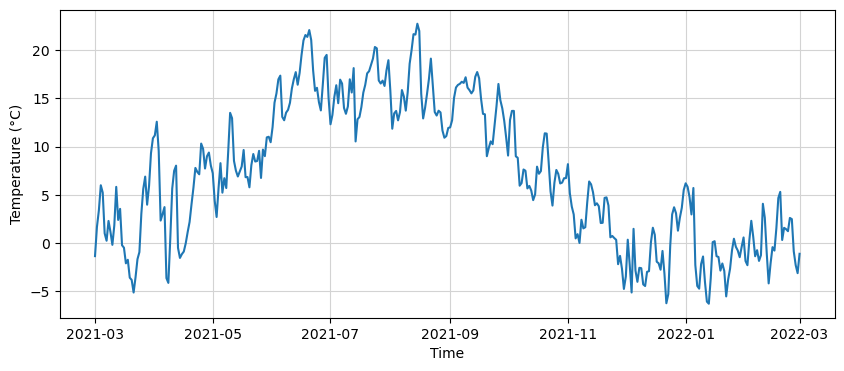

In [ ]:
overall_avg_temp = pl.read_csv(r'C:\Users\pana\Desktop\DATA\ckw\temperatures_daily.csv')

plot_range = pl.datetime_range(datetime(2021,3,1), datetime(2022,3,1), "1d",eager=True)
plt.figure(figsize = (10,4))
plt.plot(plot_range, overall_avg_temp['mean_t2m'])
plt.ylabel("Temperature (°C)")
plt.xlabel("Time")
plt.grid(True, color = 'lightgray')
plt.savefig('Temperature_year.png')
plt.show()
overall_avg_temp = overall_avg_temp['mean_t2m']

In [ ]:
def extract_cluster_data_polars(energy_data_3d, cluster_indices_df, timestamp_range):

    # Step 2: Initialize dictionaries to store energy sums and counts per cluster
    cluster_sums_energy = {i: np.zeros((366,)) for i in range(1, 5)}  # Assuming clusters 1 to 4
    cluster_counts = {i: 0 for i in range(1, 5)}
    
    # Step 3: Filter cluster indices and accumulate sums for each cluster
    for cluster in range(1, 5):  # Iterate over clusters 1 to 4
        # Get the indices of files for the current cluster
        file_indices = cluster_indices_df.filter(pl.col("cluster") == cluster)['index'].to_list()
        
        # Sum the energy consumption for these files
        for idx in file_indices:
            cluster_sums_energy[cluster] += energy_data_3d[idx].flatten()  # Ensure shape (366,)
            cluster_counts[cluster] += 1
    
    # Step 4: Dictionary to store the resulting DataFrames for each cluster
    cluster_dfs = {}
    
    # Step 5: Compute averages and create DataFrames for each cluster using Polars
    for cluster in range(1, 5):  # Change to range(1, 5) for clusters 1-4
        # Avoid division by zero
        if cluster_counts[cluster] > 0:
            avg_energy = cluster_sums_energy[cluster] / cluster_counts[cluster]
        else:
            avg_energy = np.zeros((366,))
        
        # Create a Polars DataFrame for the cluster (temperature is the same for all clusters)
        cluster_df = pl.DataFrame({
            'date': timestamp_range,                  # Use Polars Series of timestamps directly
            'avg_energy_consumption': avg_energy,     # Average energy per cluster
            'avg_temperature': overall_avg_temp       # Overall temperature (same for all clusters)
        })
        
        # Store the DataFrame in the dictionary
        cluster_dfs[cluster] = cluster_df
    
    return cluster_dfs

timestamp_range= pl.datetime_range(datetime(2021,3,1), datetime(2022,3,1), "1d",eager=True)
energy_data_3d = load_and_preprocess(file_paths,timestamp_range)

# Extract the cluster data using Polars
cluster_dataframes = extract_cluster_data_polars(energy_data_3d, cluster_indices_df, timestamp_range)

# Assign each cluster's DataFrame to a separate variable
cluster_1_df = cluster_dataframes[1]  # Cluster 1
cluster_2_df = cluster_dataframes[2]  # Cluster 2
cluster_3_df = cluster_dataframes[3]  # Cluster 3
cluster_4_df = cluster_dataframes[4]  # Cluster 4

# Optionally, print a few rows to verify
print(cluster_1_df.head())  # First few rows of cluster 1
print(cluster_2_df.head())  # First few rows of cluster 2


0 done
Shape of the 3D array: (4959, 366, 1)
shape: (5, 3)
┌─────────────────────┬────────────────────────┬─────────────────┐
│ date                ┆ avg_energy_consumption ┆ avg_temperature │
│ ---                 ┆ ---                    ┆ ---             │
│ datetime[μs]        ┆ f64                    ┆ f64             │
╞═════════════════════╪════════════════════════╪═════════════════╡
│ 2021-03-01 00:00:00 ┆ 0.513996               ┆ -1.372          │
│ 2021-03-02 00:00:00 ┆ 0.429931               ┆ 1.652333        │
│ 2021-03-03 00:00:00 ┆ 0.454291               ┆ 3.374333        │
│ 2021-03-04 00:00:00 ┆ 0.434824               ┆ 5.981167        │
│ 2021-03-05 00:00:00 ┆ 0.375594               ┆ 5.218333        │
└─────────────────────┴────────────────────────┴─────────────────┘
shape: (5, 3)
┌─────────────────────┬────────────────────────┬─────────────────┐
│ date                ┆ avg_energy_consumption ┆ avg_temperature │
│ ---                 ┆ ---                    ┆ ---    

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def linear_gam_func(daily_df):
    y = daily_df['avg_energy_consumption'].to_numpy()

    if no_of_features == 2:
        X = daily_df[['avg_temperature','month']].to_numpy()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        linear_gam = LinearGAM(s(0) + s(1)).fit(X_train, y_train)
    else:
        X = daily_df['avg_temperature'].to_numpy().reshape(-1, 1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        linear_gam = LinearGAM(s(0)).fit(X_train, y_train)

    y_pred = linear_gam.predict(X_test)
    # Mean Squared Error (MSE)
    lgam_mse = mean_squared_error(y_test, y_pred)

    # Root Mean Squared Error (RMSE)
    lgam_rmse = np.sqrt(lgam_mse)

    # Mean Absolute Error (MAE)
    lgam_mae = mean_absolute_error(y_test, y_pred)

    # R-squared (R²)
    lgam_r2 = r2_score(y_test, y_pred)

    print(f"Linear GAM model with {no_of_features} features")
    print(f"Mean Squared Error (MSE): {lgam_mse}")
    print(f"Root Mean Squared Error (RMSE): {lgam_rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {lgam_mae:.4f}")
    print(f"R-squared (R²): {lgam_r2:.4f}")

    return linear_gam
# Print the model summary
#print(linear_gam.summary())

In [ ]:
from pygam import GAM, s
def gam_func(daily_df):
    y_gam = daily_df['avg_energy_consumption']
    
    if no_of_features ==2:
        X_gam = daily_df[['avg_temperature', 'month']]
        X_train, X_test, y_train, y_test = train_test_split(X_gam, y_gam, test_size=0.2, random_state=42)
        gam = GAM(s(0, lam = 0.9) + s(1)).fit(X_gam, y_gam)
        
    else:
        X_gam = daily_df['avg_temperature']
        X_train, X_test, y_train, y_test = train_test_split(X_gam, y_gam, test_size=0.2, random_state=42)
        gam = GAM(s(0)).fit(X_train, y_train)
    
    y_pred = gam.predict(X_test)
    # Mean Squared Error (MSE)
    gam_mse = mean_squared_error(y_test, y_pred)
    
    # Root Mean Squared Error (RMSE)
    gam_rmse = np.sqrt(gam_mse)
    
    # Mean Absolute Error (MAE)
    gam_mae = mean_absolute_error(y_test, y_pred)
    
    # R-squared (R²)
    gam_r2 = r2_score(y_test, y_pred)
    
    print(f"GAM model with {no_of_features} features")
    print(f"Mean Squared Error (MSE): {gam_mse}")
    print(f"Root Mean Squared Error (RMSE): {gam_rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {gam_mae:.4f}")
    print(f"R-squared (R²): {gam_r2:.4f}")

    return gam
# Print the model summary
#print(linear_gam.summary())

In [ ]:
def smooth_term(daily_df_pandas,gam):
    # Generate a range of temperature values
    temperature_range = np.linspace(daily_df_pandas['avg_temperature'].min(), daily_df_pandas['avg_temperature'].max(), 100)
    
    # Create a DataFrame for temperature values with a placeholder for month
    temperature_df = pl.DataFrame({
        'avg_temperature': temperature_range,
    #    'month': [daily_df_pandas['month'].mean()] * len(temperature_range)  # Use mean value of month
    })
    
    # Compute partial dependence for the temperature smooth term
    s_temp = gam.partial_dependence(term=0, X=temperature_df.to_pandas())
    
    # Plot s(temperature) vs temperature
    plt.figure(figsize=(6, 4))
    
    #plt.subplot(1, 2, 1)
    plt.plot(temperature_range, s_temp, label='s(Temperature)', color='b')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Temperature')
    plt.ylabel('s(Temperature)')
    plt.title('Smooth Term s(Temperature) vs Temperature')
    plt.legend()
    plt.grid(True, alpha= 0.5, color= 'lightgray')

    return s_temp

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
def LR_func(daily_df):
    #X = daily_df[['avg_temperature','month']].to_numpy()
    X = daily_df['avg_temperature'].to_numpy().reshape(-1,1)
    y = daily_df['avg_energy_consumption'].to_numpy()
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   # 20 % of data alloted for testing
    
    # Define and fit the linear regression model
    linear_model = LinearRegression()
    linear_model.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = linear_model.predict(X_test)
    
    # Mean Squared Error (MSE)
    lreg_mse = mean_squared_error(y_test, y_pred)
    
    # Root Mean Squared Error (RMSE)
    lreg_rmse = np.sqrt(lreg_mse)
    
    # Mean Absolute Error (MAE)
    lreg_mae = mean_absolute_error(y_test, y_pred)
    
    # R-squared (R²)
    lreg_r2 = r2_score(y_test, y_pred)
    
    print("Linear Regression Model")
    print(f"Mean Squared Error (MSE): {lreg_mse}")
    print(f"Root Mean Squared Error (RMSE): {lreg_rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {lreg_mae:.4f}")
    print(f"R-squared (R²): {lreg_r2:.4f}")

    return linear_model

Linear Regression Model
Mean Squared Error (MSE): 0.0016015860927034663
Root Mean Squared Error (RMSE): 0.0400
Mean Absolute Error (MAE): 0.0333
R-squared (R²): 0.7562
GAM model with 1 features
Mean Squared Error (MSE): 0.001629621006237714
Root Mean Squared Error (RMSE): 0.0404
Mean Absolute Error (MAE): 0.0334
R-squared (R²): 0.7519


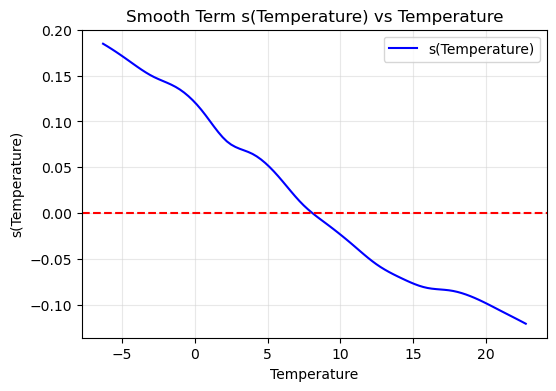

In [ ]:
no_of_features = 1
linear_1 = LR_func(cluster_1_df)
gam_1 = gam_func(cluster_1_df)
s_temp_1 = smooth_term(cluster_1_df, gam_1)

Linear Regression Model
Mean Squared Error (MSE): 0.008986187184469387
Root Mean Squared Error (RMSE): 0.0948
Mean Absolute Error (MAE): 0.0683
R-squared (R²): 0.4631
GAM model with 1 features
Mean Squared Error (MSE): 0.008474866838857844
Root Mean Squared Error (RMSE): 0.0921
Mean Absolute Error (MAE): 0.0653
R-squared (R²): 0.4936


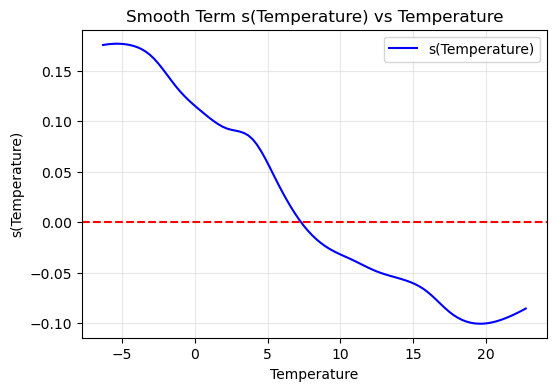

In [ ]:
linear_2 = LR_func(cluster_2_df)
gam_2 = gam_func(cluster_2_df)
s_temp_2 = smooth_term(cluster_2_df, gam_2)

Linear Regression Model
Mean Squared Error (MSE): 0.014895630182447397
Root Mean Squared Error (RMSE): 0.1220
Mean Absolute Error (MAE): 0.0698
R-squared (R²): -0.1079
GAM model with 1 features
Mean Squared Error (MSE): 0.014397092186205596
Root Mean Squared Error (RMSE): 0.1200
Mean Absolute Error (MAE): 0.0676
R-squared (R²): -0.0708


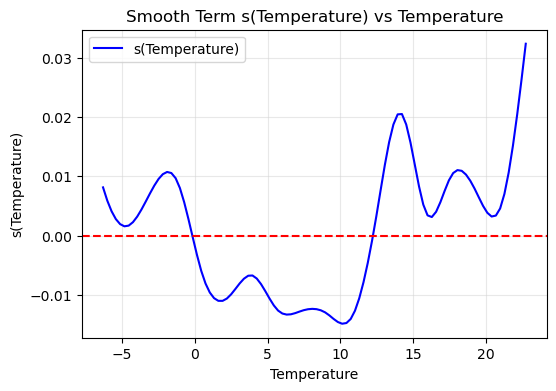

In [ ]:
linear_3 = LR_func(cluster_3_df)
gam_3 = gam_func(cluster_3_df)
s_temp_3 = smooth_term(cluster_3_df, gam_3)

Linear Regression Model
Mean Squared Error (MSE): 0.0
Root Mean Squared Error (RMSE): 0.0000
Mean Absolute Error (MAE): 0.0000
R-squared (R²): 1.0000
did not converge
GAM model with 1 features
Mean Squared Error (MSE): 0.0
Root Mean Squared Error (RMSE): 0.0000
Mean Absolute Error (MAE): 0.0000
R-squared (R²): 1.0000


C:\Users\pana\AppData\Roaming\Python\Python38\site-packages\pygam\pygam.py:806: RuntimeWarning: divide by zero encountered in scalar divide
  diff = np.linalg.norm(self.coef_ - coef_new) / np.linalg.norm(coef_new)
C:\Users\pana\AppData\Roaming\Python\Python38\site-packages\pygam\pygam.py:806: RuntimeWarning: invalid value encountered in scalar divide
  diff = np.linalg.norm(self.coef_ - coef_new) / np.linalg.norm(coef_new)
C:\Users\pana\AppData\Roaming\Python\Python38\site-packages\scipy\stats\_distn_infrastructure.py:2134: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\pana\AppData\Roaming\Python\Python38\site-packages\pygam\distributions.py:199: RuntimeWarning: invalid value encountered in divide
  dev /= self.scale
C:\Users\pana\AppData\Roaming\Python\Python38\site-packages\pygam\pygam.py:1292: RuntimeWarning: invalid value encountered in scalar divide
  score = score / rank


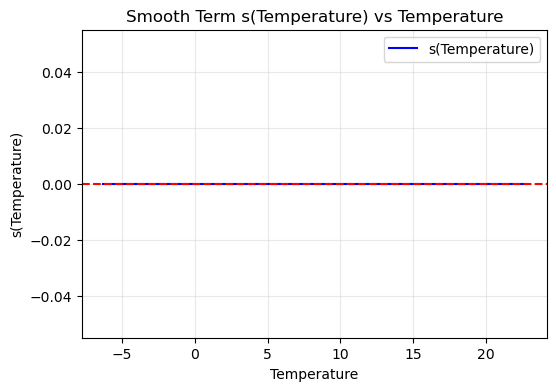

In [ ]:
linear_4 = LR_func(cluster_4_df)
gam_4 = gam_func(cluster_4_df)
s_temp_4 = smooth_term(cluster_4_df, gam_4)

C:\Users\pana\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
C:\Users\pana\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
C:\Users\pana\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
C:\Users\pana\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


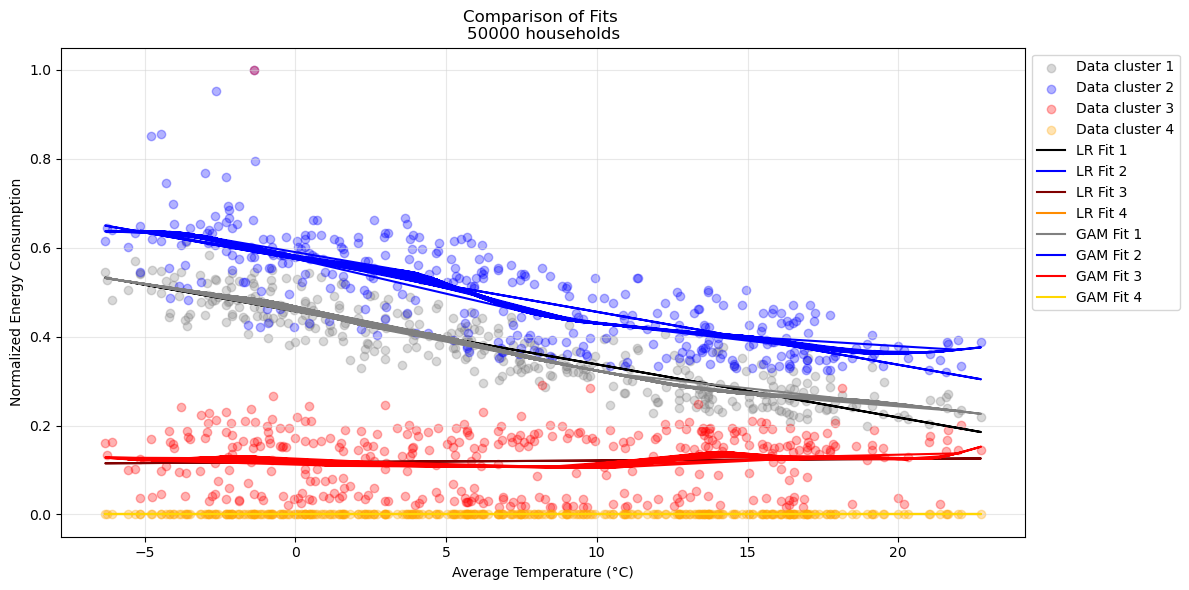

In [ ]:
# Plot the data and model predictions
plt.figure(figsize=(12, 6))

# Scatter plot of the actual data

plt.scatter(cluster_1_df['avg_temperature'], cluster_1_df['avg_energy_consumption'], alpha=0.3, label='Data cluster 1', color ='gray')
plt.scatter(cluster_2_df['avg_temperature'], cluster_2_df['avg_energy_consumption'], alpha=0.3, label='Data cluster 2', color ='blue')
plt.scatter(cluster_3_df['avg_temperature'], cluster_3_df['avg_energy_consumption'], alpha=0.3, label='Data cluster 3', color ='red')
plt.scatter(cluster_4_df['avg_temperature'], cluster_4_df['avg_energy_consumption'], alpha=0.3, label='Data cluster 4', color ='orange')
#plt.scatter(daily_df['avg_temperature'], daily_df['avg_energy_consumption'], alpha=0.3, label='Data cluster 3', color ='orange')
# Sorting by 'avg_temperature' for proper prediction plotting
if no_of_features == 2:
    # Sort by temperature and retain month for multiple predictors
    #sorted_df = daily_df.sort_values(by='avg_temperature')
    
    # Plot predictions from linear regression
    plt.plot(
        sorted_df['avg_temperature'], 
        linear_model.predict(sorted_df[['avg_temperature', 'month']]), 
        color='black', 
        label='Linear Regression Fit'
    )
    
    # Plot predictions from GAM model
    plt.plot(
        sorted_df['avg_temperature'], 
        gam.predict(sorted_df[['avg_temperature', 'month']]), 
        color='red', 
        label='GAM Fit'
    )

else:
    # Sort by temperature for single predictor
    #sorted_df = daily_df.sort_values(by='avg_temperature')
    
    # Plot predictions from linear regression
    plt.plot(
        cluster_1_df['avg_temperature'], 
        linear_1.predict(cluster_1_df[['avg_temperature']]), 
        color='black', 
        label='LR Fit 1'
    )
        # Plot predictions from linear regression
    plt.plot(
        cluster_2_df['avg_temperature'], 
        linear_2.predict(cluster_2_df[['avg_temperature']]), 
        color='blue', 
        label='LR Fit 2'
    )
    plt.plot(
        cluster_3_df['avg_temperature'], 
        linear_3.predict(cluster_3_df[['avg_temperature']]), 
        color='maroon', 
        label='LR Fit 3'
    )
        
    # Plot predictions from linear regression
    plt.plot(
        cluster_4_df['avg_temperature'], 
        linear_4.predict(cluster_4_df[['avg_temperature']]), 
        color='darkorange', 
        label='LR Fit 4'
    )
    
    # Plot predictions from GAM model
    plt.plot(
        cluster_1_df['avg_temperature'], 
        gam_1.predict(cluster_1_df[['avg_temperature']]), 
        color='gray', 
        label='GAM Fit 1'
    )
    
    # Plot predictions from GAM model
    plt.plot(
        cluster_2_df['avg_temperature'], 
        gam_2.predict(cluster_2_df[['avg_temperature']]), 
        color='blue', 
        label='GAM Fit 2'
    )
    # Plot predictions from GAM model
    plt.plot(
        cluster_3_df['avg_temperature'], 
        gam_3.predict(cluster_3_df[['avg_temperature']]), 
        color='red', 
        label='GAM Fit 3'
    )

    # Plot predictions from GAM model
    plt.plot(
        cluster_4_df['avg_temperature'], 
        gam_4.predict(cluster_4_df[['avg_temperature']]), 
        color="gold", 
        label='GAM Fit 4'
    )
# Adding labels, title, and grid
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Normalized Energy Consumption')
plt.title('Comparison of Fits \n50000 households')
#plt.ylim(0,2.25)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, alpha=0.5, color='lightgray')
plt.savefig(f'comparison_{no_of_features}_feature_all_clusters_normalized_daily.png', bbox_inches='tight')
plt.tight_layout()
# Display the plot
plt.show()

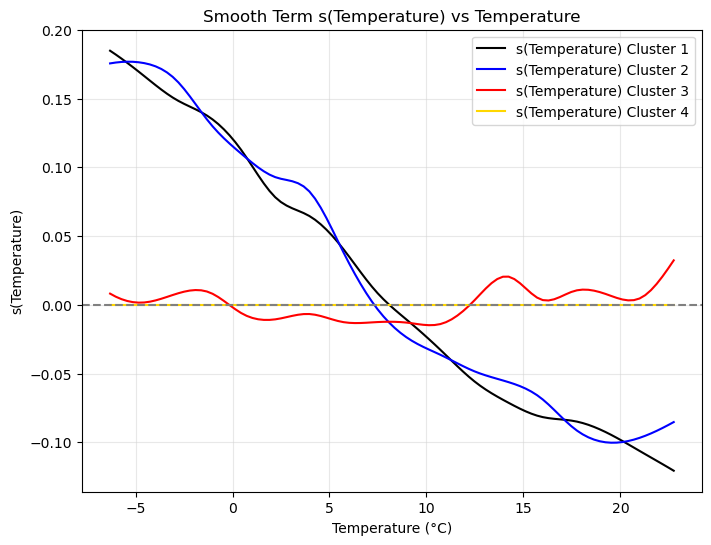

In [ ]:
# Plot s(temperature) vs temperature
plt.figure(figsize=(8, 6))

#plt.subplot(1, 2, 1)
temperature_range = np.linspace(cluster_1_df['avg_temperature'].min(), cluster_1_df['avg_temperature'].max(), 100)
plt.plot(temperature_range, s_temp_1, label='s(Temperature) Cluster 1', color='black')
plt.plot(temperature_range, s_temp_2, label='s(Temperature) Cluster 2', color='blue')
plt.plot(temperature_range, s_temp_3, label='s(Temperature) Cluster 3', color='red')
plt.plot(temperature_range, s_temp_4, label='s(Temperature) Cluster 4', color='gold')
plt.axhline(y=0, color='gray', linestyle='--')
plt.xlabel('Temperature (°C)')
plt.ylabel('s(Temperature)')
plt.title('Smooth Term s(Temperature) vs Temperature')
plt.legend()
plt.grid(True, alpha= 0.5, color= 'lightgray')
plt.savefig(f'smooth_term_cluster_4_daily_normalized.png', bbox_inches='tight')